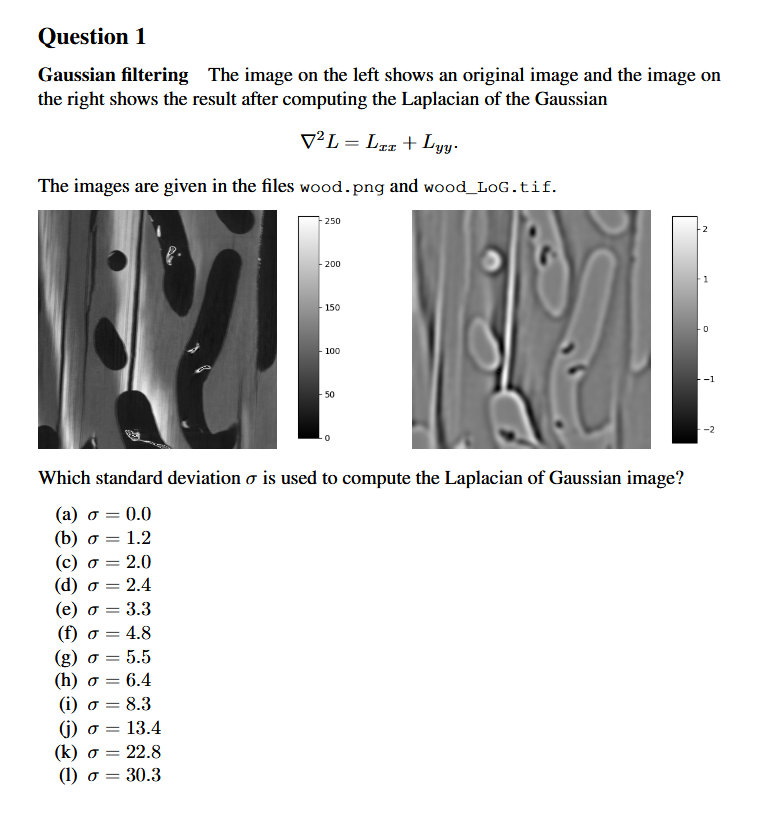

Note: you may need to restart the kernel to use updated packages.


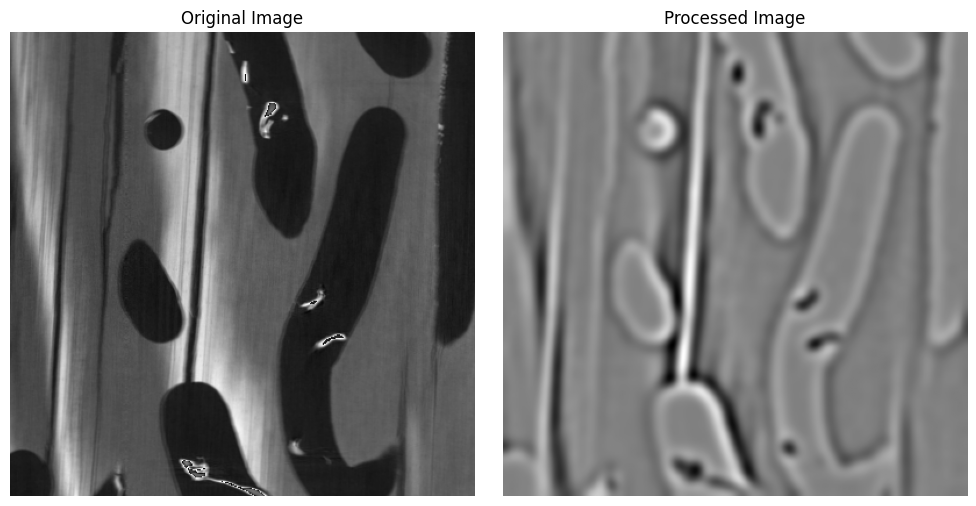

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
%pip install scipy
import numpy as np 
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter1d, gaussian_filter, gaussian_gradient_magnitude
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.io import imread

im_procesed = io.imread('data/wood_LoG.tif', as_gray=True)
im = io.imread('data/wood.png', as_gray=True).astype(np.float64)



# visualize the image 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(im_procesed, cmap='gray')
ax[1].set_title('Processed Image')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

def get_gaussian_kernels(s):
    '''
    Returns a 1D Gaussian kernel and its derivative and the x values.
    
    Parameters
    ----------
    s : float
        Standard deviation of the Gaussian kernel.
        
    Returns
    -------
    g : ndarray
        1D Gaussian kernel.
    dg : ndarray
        Derivative of the Gaussian kernel.
    x : ndarray
        x values where the Gaussian is computed.
    '''
    # Variance of the Gaussian
    t = s**2
    # Range for the kernel: covers ±4 standard deviations
    r = np.ceil(4 * s)
    # x values for the kernel, column vector
    x = np.arange(-r, r + 1).reshape(-1, 1)
    # Compute the Gaussian kernel
    g = np.exp(-x**2 / (2 * t))
    # Normalize the kernel so that its sum is 1
    g = g / np.sum(g)
    # Compute the derivative of the Gaussian kernel
    dg = -x * g / t 
    return g, dg, x

def get_gaussian_second_derivative(s):
    '''
    Returns the second derivative of a 1D Gaussian kernel.
    
    Parameters
    ----------
    s : float
        Standard deviation of the Gaussian kernel.
        
    Returns
    -------
    d2g : ndarray
        Second derivative of the Gaussian kernel.
    '''
    # Variance of the Gaussian
    t = s**2
    # Range for the kernel: covers ±4 standard deviations
    r = np.ceil(4 * s)
    # x values for the kernel, column vector
    x = np.arange(-r, r + 1).reshape(-1, 1)
    # Compute the Gaussian kernel
    g = np.exp(-x**2 / (2 * t))
    # Normalize the kernel so that its sum is 1
    g = g / np.sum(g)
    # Compute the second derivative of the Gaussian kernel
    d2g = (x**2 / t**2 - 1 / t) * g
    return d2g

def convolve_columns(image, kernel_1D):
    """Apply 1D convolution along columns (vertical direction)."""
    column_wise_gaussian_kernel = kernel_1D.reshape(-1, 1)
    return convolve(image, column_wise_gaussian_kernel)

def convolve_rows(image, kernel_1D):
    """Apply 1D convolution along rows (horizontal direction)."""
    row_wise_gaussian_kernel = kernel_1D.reshape(1, -1)
    return convolve(image, row_wise_gaussian_kernel)

class GaussianFilterChain:
    """
    A class for applying and chaining Gaussian filtering operations.
    
    This allows for flexible specification of filtering sequences and 
    provides plotting capabilities.
    """
    
    def __init__(self, image):
        """
        Initialize with an input image.
        
        Parameters
        ----------
        image : ndarray
            Input image to be filtered.
        """
        self.original_image = image.copy()
        self.current_image = image.copy()
        self.history = [('original', image.copy())]
        
    def apply_operation(self, operation, direction, std_dev, label=None):
        """
        Apply a single Gaussian filtering operation.
        
        Parameters
        ----------
        operation : str
            Type of operation: 'gaussian', 'derivative', 'second_derivative'
        direction : str
            Direction: 'horizontal', 'vertical', 'both'
        std_dev : float
            Standard deviation for the Gaussian kernel
        label : str, optional
            Label for this operation in the history
            
        Returns
        -------
        self : GaussianFilterChain
            Returns self for method chaining
        """
        if operation == 'gaussian':
            g, dg, x = get_gaussian_kernels(std_dev)
            kernel = g.flatten()
        elif operation == 'derivative':
            g, dg, x = get_gaussian_kernels(std_dev)
            kernel = dg.flatten()
        elif operation == 'second_derivative':
            kernel = get_gaussian_second_derivative(std_dev).flatten()
        else:
            raise ValueError("operation must be 'gaussian', 'derivative', or 'second_derivative'")
        
        if direction == 'horizontal':
            result = convolve_rows(self.current_image, kernel)
        elif direction == 'vertical':
            result = convolve_columns(self.current_image, kernel)
        elif direction == 'both':
            # Apply to both directions and sum (like Laplacian)
            result_h = convolve_rows(self.current_image, kernel)
            result_v = convolve_columns(self.current_image, kernel)
            result = result_h + result_v
        else:
            raise ValueError("direction must be 'horizontal', 'vertical', or 'both'")
        
        self.current_image = result
        
        # Create label for history
        if label is None:
            label = f"{operation}_{direction}_std{std_dev}"
        
        self.history.append((label, result.copy()))
        return self
    
    def gaussian(self, direction, std_dev, label=None):
        """Apply Gaussian smoothing."""
        return self.apply_operation('gaussian', direction, std_dev, label)
    
    def derivative(self, direction, std_dev, label=None):
        """Apply first-order Gaussian derivative."""
        return self.apply_operation('derivative', direction, std_dev, label)
    
    def second_derivative(self, direction, std_dev, label=None):
        """Apply second-order Gaussian derivative."""
        return self.apply_operation('second_derivative', direction, std_dev, label)
    
    def laplacian_of_gaussian(self, std_dev, label=None):
        """
        Apply Laplacian of Gaussian (∂²I/∂x² + ∂²I/∂y²).
        This is a convenience method that applies the full LoG operation.
        """
        g, dg, x = get_gaussian_kernels(std_dev)
        d2g = get_gaussian_second_derivative(std_dev)
        
        # ∂²I/∂x²: second derivative in x, smoothing in y
        temp1 = convolve_rows(self.current_image, d2g.flatten())
        result1 = convolve_columns(temp1, g.flatten())
        
        # ∂²I/∂y²: smoothing in x, second derivative in y
        temp2 = convolve_rows(self.current_image, g.flatten())
        result2 = convolve_columns(temp2, d2g.flatten())
        
        # Sum the results
        result = result1 + result2
        self.current_image = result
        
        if label is None:
            label = f"LoG_std{std_dev}"
        
        self.history.append((label, result.copy()))
        return self
    
    def get_result(self):
        """Get the current filtered image."""
        return self.current_image
    
    def get_history(self):
        """Get the complete history of operations."""
        return self.history
    
    def plot_history(self, figsize=(15, 10), cmap='gray'):
        """
        Plot the complete history of filtering operations.
        
        Parameters
        ----------
        figsize : tuple
            Figure size for the plot
        cmap : str
            Colormap for displaying images
        """
        n_images = len(self.history)
        cols = min(4, n_images)
        rows = (n_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if rows == 1:
            axes = axes.reshape(1, -1) if n_images > 1 else [axes]
        elif cols == 1:
            axes = axes.reshape(-1, 1)
        
        for i, (label, image) in enumerate(self.history):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            im = ax.imshow(image, cmap=cmap)
            ax.set_title(label, fontsize=10)
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Hide empty subplots
        for i in range(n_images, rows * cols):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
            
    def plot_history_2(self, figsize=(15, 10), cmap='gray'):
        """
        Plot the complete history of filtering operations, with normalization.

        Parameters
        ----------
        figsize : tuple
            Figure size for the plot
        cmap : str
            Colormap for displaying images
        """
        n_images = len(self.history)
        cols = min(4, n_images)
        rows = (n_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=figsize)

        # Ensure axes is always a 2D array for easier indexing
        if rows == 1:
            axes = axes.reshape(1, -1)
        elif cols == 1:
            axes = axes.reshape(-1, 1)

        for i, (label, image) in enumerate(self.history):
            row = i // cols
            col = i % cols
            ax = axes[row, col]

            # Normalize the image for display
            img_norm = (image - np.min(image)) / (np.max(image) - np.min(image)) if np.max(image) != np.min(image) else image
            im = ax.imshow(img_norm, cmap=cmap)
            ax.set_title(label, fontsize=10)
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Hide empty subplots
        for i in range(n_images, rows * cols):
            row = i // cols
            col = i % cols
            ax = axes[row, col]
            ax.axis('off')

        plt.tight_layout()
        plt.show()
    
    def plot_result(self, figsize=(8, 6), cmap='gray', title=None):
        """
        Plot only the final result.
        
        Parameters
        ----------
        figsize : tuple
            Figure size for the plot
        cmap : str
            Colormap for displaying the image
        title : str, optional
            Title for the plot
        """
        
        # normalize the result 
        self.current_image = (self.current_image - np.min(self.current_image)) / (np.max(self.current_image) - np.min(self.current_image))
        
        plt.figure(figsize=figsize)
        plt.imshow(self.current_image, cmap=cmap)
        if title is None:
            title = f"Final Result (after {len(self.history)-1} operations)"
        plt.title(title)
        plt.colorbar()
        plt.axis('off')
        plt.show()

# Convenience functions for the original filter types
def filter_type_a(image, std_dev=10):
    """(a) 1D first-order Gaussian derivative horizontally only"""
    return (GaussianFilterChain(image)
            .derivative('horizontal', std_dev, 'horizontal_derivative_only')
            .get_result())

def filter_type_b(image, variance=10):
    """(b) 1D Gaussian smoothing horizontally + 1D first-order derivative vertically"""
    std_dev = np.sqrt(variance)
    return (GaussianFilterChain(image)
            .gaussian('horizontal', std_dev, 'horizontal_smoothing')
            .derivative('vertical', std_dev, 'vertical_derivative')
            .get_result())

def filter_type_c(image, std_dev=4):
    """(c) Laplacian of Gaussian"""
    return (GaussianFilterChain(image)
            .laplacian_of_gaussian(std_dev)
            .get_result())

def filter_type_d(image, std_dev=7):
    """(d) 1D first-order derivative horizontally then vertically"""
    return (GaussianFilterChain(image)
            .derivative('horizontal', std_dev, 'horizontal_derivative')
            .derivative('vertical', std_dev, 'vertical_derivative')
            .get_result())

# Example usage functions
def demo_filter_chains(image):
    """
    Demonstrate all filter types with plotting.
    
    Parameters
    ----------
    image : ndarray
        Input image to filter
    """
    print("Filter Type A: Horizontal derivative only")
    chain_a = GaussianFilterChain(image).derivative('horizontal', 10, 'horizontal_derivative_only')
    chain_a.plot_history()
    
    print("\nFilter Type B: Horizontal smoothing + vertical derivative")
    std_dev = np.sqrt(10)
    chain_b = (GaussianFilterChain(image)
               .gaussian('horizontal', std_dev, 'horizontal_smoothing')
               .derivative('vertical', std_dev, 'vertical_derivative'))
    chain_b.plot_history()
    
    print("\nFilter Type C: Laplacian of Gaussian")
    chain_c = GaussianFilterChain(image).laplacian_of_gaussian(4)
    chain_c.plot_history()
    
    print("\nFilter Type D: Horizontal then vertical derivatives")
    chain_d = (GaussianFilterChain(image)
               .derivative('horizontal', 7, 'horizontal_derivative')
               .derivative('vertical', 7, 'vertical_derivative'))
    chain_d.plot_history()
    
    return chain_a, chain_b, chain_c, chain_d

In [4]:
import numpy as np
from skimage import io
from sklearn.metrics import mean_squared_error
from scipy.ndimage import convolve

def get_gaussian_kernels(s):
    t = s**2
    r = np.ceil(4 * s)
    x = np.arange(-r, r + 1).reshape(-1, 1)
    g = np.exp(-x**2 / (2 * t))
    g = g / np.sum(g)
    return g

def get_gaussian_second_derivative(s):
    t = s**2
    r = np.ceil(4 * s)
    x = np.arange(-r, r + 1).reshape(-1, 1)
    g = np.exp(-x**2 / (2 * t))
    g = g / np.sum(g)
    d2g = (x**2 / t**2 - 1 / t) * g
    return d2g

def laplacian_of_gaussian(image, std_dev):
    """Apply Laplacian of Gaussian to image"""
    g = get_gaussian_kernels(std_dev).flatten()
    d2g = get_gaussian_second_derivative(std_dev).flatten()
    
    # ∂²I/∂x²: second derivative in x, smoothing in y
    temp1 = convolve(image, d2g.reshape(1, -1))  # rows
    result1 = convolve(temp1, g.reshape(-1, 1))  # columns
    
    # ∂²I/∂y²: smoothing in x, second derivative in y
    temp2 = convolve(image, g.reshape(1, -1))    # rows
    result2 = convolve(temp2, d2g.reshape(-1, 1)) # columns
    
    return result1 + result2

# Load images
im_processed = io.imread('data/wood_LoG.tif', as_gray=True)
im = io.imread('data/wood.png', as_gray=True).astype(np.float64)

# Test sigma values
sigma_values = [0.0, 1.2, 2.0, 2.4, 3.3, 4.8, 5.5, 6.4, 8.3, 13.4, 22.8, 30.3]
sigma_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

results = []

print("Testing sigma values...")
for i, sigma in enumerate(sigma_values):
    if sigma == 0.0:
        print(f"({sigma_labels[i]}) σ = {sigma:.1f}: Skipped")
        continue
    
    # Compute LoG
    log_result = laplacian_of_gaussian(im, sigma)
    
    # Normalize both images
    log_norm = (log_result - log_result.min()) / (log_result.max() - log_result.min())
    processed_norm = (im_processed - im_processed.min()) / (im_processed.max() - im_processed.min())
    
    # Calculate MSE
    mse = mean_squared_error(processed_norm.flatten(), log_norm.flatten())
    results.append((sigma_labels[i], sigma, mse))
    
    print(f"({sigma_labels[i]}) σ = {sigma:.1f}: MSE = {mse:.6f}")

# Find best match
best = min(results, key=lambda x: x[2])
print(f"\nBEST MATCH: ({best[0]}) σ = {best[1]:.1f} with MSE = {best[2]:.6f}")
print(f"Answer: {best[0]}")

Testing sigma values...
(a) σ = 0.0: Skipped
(b) σ = 1.2: MSE = 0.011899
(c) σ = 2.0: MSE = 0.034837
(d) σ = 2.4: MSE = 0.021375
(e) σ = 3.3: MSE = 0.005061
(f) σ = 4.8: MSE = 0.000418
(g) σ = 5.5: MSE = 0.000000
(h) σ = 6.4: MSE = 0.001335
(i) σ = 8.3: MSE = 0.003782
(j) σ = 13.4: MSE = 0.014332
(k) σ = 22.8: MSE = 0.027714
(l) σ = 30.3: MSE = 0.032633

BEST MATCH: (g) σ = 5.5 with MSE = 0.000000
Answer: g
